In [ ]:
import torch
import io
import pandas as pd
from transformers import LongformerTokenizer
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

torch.cuda.is_available()

True

In [ ]:
# !pip install transformers

In [ ]:
df = pd.read_csv("../../data/preprocessed_sub_and_body.csv")
df["body"] = df["body"].astype(str)
df["label"] = df["label"].astype(int)

In [ ]:
# Tokenization
tokenizer = LongformerTokenizer.from_pretrained("allenai/longformer-base-4096")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
average_length = df["length"].mean()
max_length = df["length"].max()
min_length = df["length"].min()

print(f"Average length: {average_length}")
print(f"Max length: {max_length}")
print(f"Min length: {min_length}")

In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    df["body"], df["label"], stratify=df["label"], test_size=0.2
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, random_state=42, test_size=0.2
)

Maksimalna duzina sekvence je 1024 zbog ogranicenih resursa

In [ ]:
def encode_data(input_text):
    tokens = tokenizer.batch_encode_plus(
        input_text,
        add_special_tokens=True,
        truncation=True,
        max_length=1024,
        padding=True,
        return_attention_mask=True,
        return_tensors="pt",
    )
    return tokens["input_ids"], tokens["attention_mask"]


train_input_ids, train_attention_masks = encode_data(list(X_train))
val_input_ids, val_attention_masks = encode_data(list(X_val))

# convert labels to PyTorch tensors
train_labels = torch.tensor(y_train.values, dtype=torch.float32)
val_labels = torch.tensor(y_val.values, dtype=torch.float32)

In [ ]:
train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)

Koristićemo LongformerForSequenceClassification. 

Za optimizaciju ćemo koristiti AdamW optimizer sa *learning-rate*-om postavljenim na 2e−5.

Za loss funkciju je odabrana CrossEntropyLoss

Za *fine-tuning* biramo sljedeće hiperparametre:

- Batch size: 16 (Batch size 32 nije moguć zbog ograničenih resursa)
- Learning rate: 2e-5
- Epochs: 4


In [ ]:
batch_size = 16

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)

validation_loader = DataLoader(
    val_dataset,  
    shuffle=False,  
    batch_size=batch_size, 
)

In [ ]:
from transformers import (
    LongformerForSequenceClassification,
    AdamW,
    BertConfig,
    get_scheduler,
)

bert_model = LongformerForSequenceClassification.from_pretrained(
    "allenai/longformer-base-4096",
    num_labels=2,  # T binary classification.
    output_attentions=False,  # don't return attentions weights.
    output_hidden_states=False,  # don't return all hidden-states.
)


optimizer = AdamW(bert_model.parameters(), lr=2e-5)
loss_fn = torch.nn.CrossEntropyLoss()

num_epochs = 4

# number of training steps = [number of batches] x [number of epochs].
num_training_steps = len(train_loader) * num_epochs

# create the learning rate scheduler
lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

bert_model.to(device)

LongformerForSequenceClassification(
  (longformer): LongformerModel(
    (embeddings): LongformerEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (position_embeddings): Embedding(4098, 768, padding_idx=1)
    )
    (encoder): LongformerEncoder(
      (layer): ModuleList(
        (0-11): 12 x LongformerLayer(
          (attention): LongformerAttention(
            (self): LongformerSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (query_global): Linear(in_features=768, out_features=768, bias=True)
              (key_global): Linear(in_features=768, out_features=768, bias=True)
          

In [ ]:
progress_bar = tqdm(range(num_training_steps))


# Initialize lists to store metrics
train_losses = []
val_losses = []
val_accuracies = []
val_precisions = []
val_recalls = []
val_f1_scores = []
val_roc_aucs = []

for epoch in range(num_epochs):
    print(" Epoch {:} / {:}".format(epoch + 1, num_epochs))
    # reset the total loss for this epoch.
    total_train_loss = 0

    # put the model into training mode https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    bert_model.train()

    for i, batch in enumerate(train_loader):
        (b_input_ids, b_input_mask, b_labels) = tuple(
            t.to(device) for t in batch
        )  # send tesors to gpu

        # ensure labels are of type LongTensor
        b_labels = b_labels.long()

        # setting the gradients to zero
        optimizer.zero_grad()

        # forward pass
        outputs = bert_model(b_input_ids, attention_mask=b_input_mask)

        pred = outputs.logits
        loss = loss_fn(pred, b_labels)

        total_train_loss += loss.item()  # accumulate loss over all batches

        # backward pass/calculating gradients
        loss.backward()

        # optimizing the parameters of the bert model using computed gradient
        optimizer.step()

        # update the learning rate.
        lr_scheduler.step()

        progress_bar.update(1)

    # calculate the average loss
    epoch_train_loss = total_train_loss / len(train_loader)
    train_losses.append(epoch_train_loss)
    print(f"\nTraining epoch {epoch + 1} loss: ", epoch_train_loss)

    print("Training complete!")

    # TESTING BLOCK STARTS

    total_val_loss = 0

    # put the model in evaluation mode
    bert_model.eval()
    all_val_preds = []
    all_val_labels = []

    for i, batch in enumerate(validation_loader):
        (b_input_ids, b_input_mask, b_labels) = tuple(t.to(device) for t in batch)

        b_labels = b_labels.long()

        with torch.no_grad():
            outputs = bert_model(b_input_ids, attention_mask=b_input_mask)

        logits = outputs.logits
        loss = loss_fn(logits, b_labels)

        total_val_loss += loss.item()

        preds = torch.argmax(logits, dim=-1)
        all_val_preds.extend(preds.cpu().numpy())
        all_val_labels.extend(b_labels.cpu().numpy())

    epoch_val_loss = total_val_loss / len(validation_loader)
    accuracy = accuracy_score(all_val_labels, all_val_preds)
    precision = precision_score(all_val_labels, all_val_preds, average="binary")
    recall = recall_score(all_val_labels, all_val_preds, average="binary")
    f1 = f1_score(all_val_labels, all_val_preds, average="binary")
    roc_auc = roc_auc_score(all_val_labels, all_val_preds)

    print(f"\nValidation epoch {epoch + 1} loss: {epoch_val_loss}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"ROC-AUC: {roc_auc}")

    val_losses.append(epoch_val_loss)
    val_accuracies.append(accuracy)
    val_precisions.append(precision)
    val_recalls.append(recall)
    val_f1_scores.append(f1)
    val_roc_aucs.append(roc_auc)

    #  # Early stopping
    # if avg_val_loss < best_val_loss or f1 > best_f1:
    #     best_val_loss = avg_val_loss
    #     best_f1 = f1
    #     trigger_times = 0
    #     # Save the best model weights
    #     torch.save(bert_model.state_dict(), 'best_model.pt')
    # else:
    #     trigger_times += 1
    #     if trigger_times >= patience:
    #         print("Early stopping!")
    #         bert_model.load_state_dict(torch.load('best_model.pt'))
    #         break

print("")
print("Training complete!")

  0%|          | 0/3664 [00:00<?, ?it/s]

 Epoch 1 / 4

Training epoch 1 loss:  0.0006963540790383969
Training complete!

Validation epoch 1 loss: 0.04869812538247585
Accuracy: 0.990174672489083
Precision: 0.9957716701902748
Recall: 0.9853556485355649
F1 Score: 0.9905362776025236
ROC-AUC: 0.9903947192449516
 Epoch 2 / 4


In [ ]:
model_save_path = "drive/MyDrive/bert_lonformer_model.pt"
optimizer_save_path = "drive/MyDrive/longformer_optimizer.pt"

torch.save(bert_model.state_dict(), model_save_path)


torch.save(optimizer.state_dict(), optimizer_save_path)

print("Model and optimizer state saved successfully.")

Model and optimizer state saved successfully.


## Rezime i vizualizacija rezultata obučavanja

In [ ]:
# !pip install tabulate

In [ ]:
from tabulate import tabulate

table_data = [
    ["Epoch", "Train Loss", "Val Loss", "Val Acc", "Val Precision", "Val Recall", "Val F1", "Val ROC-AUC"],
]

for epoch in range(num_epochs):
    table_data.append([
        epoch + 1,
        train_losses[epoch],
        val_losses[epoch],
        val_accuracies[epoch],
        val_precisions[epoch],
        val_recalls[epoch],
        val_f1_scores[epoch],
        val_roc_aucs[epoch]
    ])

print(tabulate(table_data, headers="firstrow", floatfmt=".4f"))


  Epoch    Train Loss    Val Loss    Val Acc    Val Precision    Val Recall    Val F1    Val ROC-AUC
-------  ------------  ----------  ---------  ---------------  ------------  --------  -------------
      1        0.1275      0.0587     0.9836           0.9978        0.9707    0.9841         0.9842
      2        0.0270      0.0427     0.9902           0.9958        0.9854    0.9905         0.9904
      3        0.0106      0.0454     0.9902           0.9958        0.9854    0.9905         0.9904
      4        0.0023      0.0487     0.9902           0.9958        0.9854    0.9905         0.9904


Notice that, while the the training loss is going down with each epoch, the validation loss is increasing! This suggests that we are training our model too long, and it’s over-fitting on the training data.

(For reference, we are using 7,695 training samples and 856 validation samples).

Validation Loss is a more precise measure than accuracy, because with accuracy we don’t care about the exact output value, but just which side of a threshold it falls on.

If we are predicting the correct answer, but with less confidence, then validation loss will catch this, while accuracy will not.

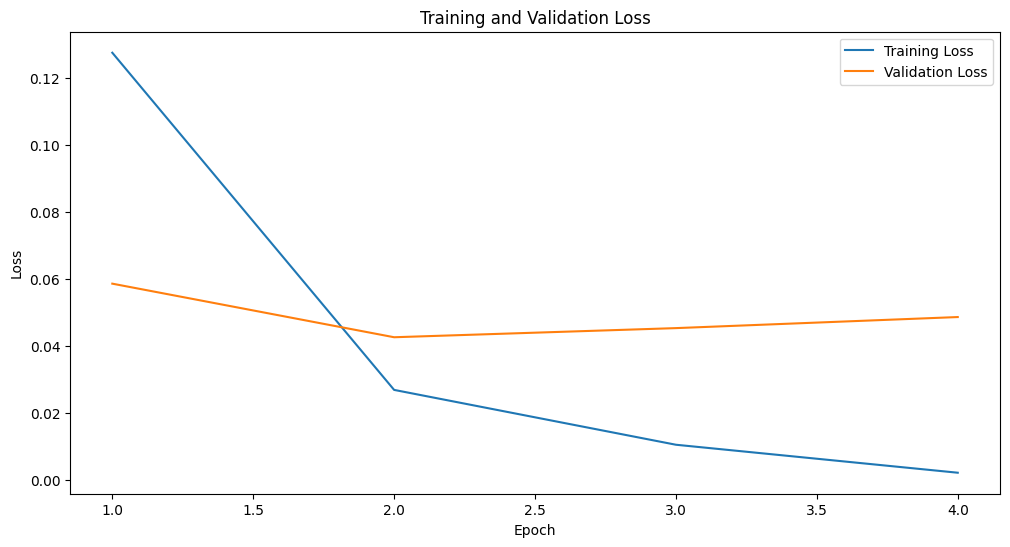

In [ ]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Primjećujemo da iako *Training loss* opada *Validation loss* raste nakon druge epohe, što nam sugeriše da nam model nakon druge epohe potencijalno overfituje

### Evaluacija nad testnim podacima

In [ ]:

test_input_ids, test_attention_masks = encode_data(list(X_test))

test_labels = torch.tensor(y_test.values, dtype=torch.long)

test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)

test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

def evaluate_model(model, dataloader, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    for batch in dataloader:
        (b_input_ids, b_input_mask, b_labels) = tuple(t.to(device) for t in batch)

        b_labels = b_labels.long()

        with torch.no_grad():
            outputs = bert_model(b_input_ids,
                             attention_mask=b_input_mask)

        logits = outputs.logits
        loss = loss_fn(logits, b_labels)

        total_loss += loss.item()

        preds = torch.argmax(logits, dim=-1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(b_labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    roc_auc = roc_auc_score(all_labels, all_preds)

     # confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    tn, fp, fn, tp = cm.ravel()  # for binary classification

    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0

    return avg_loss, accuracy, precision, recall, f1, roc_auc, fpr, fnr


(
    test_loss,
    test_accuracy,
    test_precision,
    test_recall,
    test_f1,
    test_roc_auc,
    test_fpr,
    test_fnr,
) = evaluate_model(bert_model, test_loader, device)

print(f"Test loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print(f"Test ROC-AUC: {test_roc_auc:.4f}")
print(f"Test FPR: {test_fpr:.4f}")
print(f"Test FNR: {test_fnr:.4f}")


Test loss: 0.0496
Test Accuracy: 0.9904
Test Precision: 0.9881
Test Recall: 0.9932
Test F1 Score: 0.9907
Test ROC-AUC: 0.9903
